## Recommendation Systems - Project Submission

### Problem Statement

Build your own recommendation system for products on an e-commerce website like Amazon.com. 

In [1]:
#Load the required basic data handling and visualization libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics) 

In [2]:
#Load the local copy of the data set into a dataframe
rating_df = pd.read_csv("ratings_Electronics.csv",header=None)

#Sanity
rating_df.head(3)

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600


In [3]:
#Check the basic characteristics of the dataset
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
0    object
1    object
2    float64
3    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [4]:
#Lets add column names to make it easier for visualization
rating_df.rename(columns={0: "userId",
                          1: "itemId",
                          2: "rating",
                          3: "timestamp"},inplace=True)

In [5]:
#Check the info again
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
itemId       object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [6]:
#Lets drop timestamp for this exercise as it is not going to be used for now
rating_df.drop("timestamp",axis=1,inplace=True)

In [7]:
#Check again
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId    object
itemId    object
rating    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [8]:
#check if there are any missing values in the ratings
rating_df.isna().sum()

#No missing rating values..

userId    0
itemId    0
rating    0
dtype: int64

In [9]:
#check unique users
rating_df.userId.unique().size

4201696

In [10]:
#check unique items
rating_df.itemId.unique().size

476002

In [11]:
#Lets check the distribution of the ratings
#First check the unique ratings
rating_df.rating.unique()

#As expected scale is 1 - 5

array([5., 1., 3., 2., 4.])

In [12]:
#distribution
rating_df.rating.value_counts()

#Interesting to note more good ratings than low ratings

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

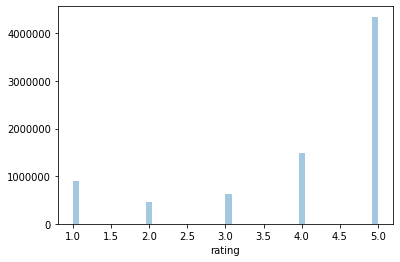

In [13]:
#Visualize the rating distribution
sns.distplot(rating_df.rating,kde=False)

#As observed from the values we seem to have significantly more 5 ratings than others

In [14]:
#What is the average rating overall
rating_df.rating.mean()

#As expected from the distribution average rating is around 4

4.012336791112817

In [15]:
#check the ratings by items
item_rating_count = pd.DataFrame(rating_df.groupby("itemId")["rating"].aggregate("count"))

In [16]:
#Check sample
item_rating_count.head()

,rating
itemId,
0132793040,1
0321732944,1
0439886341,3
0511189877,6
0528881469,27


In [17]:
#Check the ones with more count of ratings
item_rating_count.sort_values("rating",ascending=False).head()

,rating
itemId,
B0074BW614,18244
B00DR0PDNE,16454
B007WTAJTO,14172
B0019EHU8G,12285
B006GWO5WK,12226


Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) 

In [18]:
#We have few items with only 1 rating...and several with few thousand ratings
#For our exercise lets pick only the items which have more than 50 ratings
items_significant = item_rating_count[item_rating_count.rating >= 50].index

In [19]:
#Get only records where at least 50 ratings are available for the items
rating_df = rating_df[rating_df.itemId.isin(items_significant)]

In [20]:
#Check the data count now
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5374313 entries, 183 to 7824227
Data columns (total 3 columns):
userId    object
itemId    object
rating    float64
dtypes: float64(1), object(2)
memory usage: 164.0+ MB


In [21]:
#check the distribution of ratings again
rating_df.rating.value_counts()
#Many 5 ratings have dropped

5.0    3070257
4.0    1017201
1.0     572060
3.0     415370
2.0     299425
Name: rating, dtype: int64

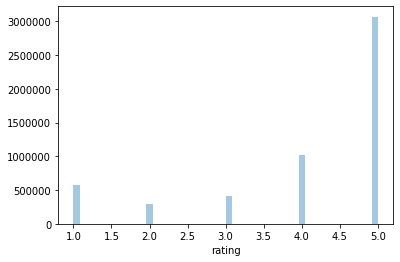

In [22]:
#Quick visualization
sns.distplot(rating_df.rating,kde=False)

In [23]:
#Check overall mean again
rating_df.rating.mean()

#Very slight change only...still 5 is significantly more

4.063237291910613

Build Popularity Recommender model. 

In [24]:
#Lets build a data frame of average ratings per item Id and sort it.
#This is basically the popularity based recommendations of items
popular_items = pd.DataFrame(rating_df.groupby("itemId").aggregate("mean")["rating"].sort_values(ascending=False))

In [25]:
#Check sample
popular_items.head()

,rating
itemId,
B002E6R7NG,4.980392
B004I763AW,4.966667
B003J9QQWU,4.964286
B0043ZLFXE,4.955556
B000TMFYBO,4.953125


In [26]:
#Get the top 5 popular items
popular_items.head(5)

,rating
itemId,
B002E6R7NG,4.980392
B004I763AW,4.966667
B003J9QQWU,4.964286
B0043ZLFXE,4.955556
B000TMFYBO,4.953125


In [27]:
##Collaborative Filtering##

In [28]:
#Keep a back up as we iterate thru in case needed
rating_bkup = rating_df

In [30]:
#Check the current record size
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5374313 entries, 183 to 7824227
Data columns (total 3 columns):
userId    object
itemId    object
rating    float64
dtypes: float64(1), object(2)
memory usage: 164.0+ MB


In [31]:
#Take a 50% sample of already reduced to avoid memory issue
rating_df_fraction = rating_df.sample(frac=0.5,replace=False,random_state=42)

In [32]:
#check for sanity
rating_df_fraction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2687156 entries, 5407551 to 6039789
Data columns (total 3 columns):
userId    object
itemId    object
rating    float64
dtypes: float64(1), object(2)
memory usage: 82.0+ MB


In [33]:
#Lets check the charateristics again in this sample
rating_df_fraction.rating.value_counts()

#Similar to the full data set

5.0    1534882
4.0     508935
1.0     286245
3.0     207497
2.0     149597
Name: rating, dtype: int64

In [34]:
#Lets again pick only those items which got at least 50 ratings
#First group by rating count for manipulation
gp = pd.DataFrame(rating_df_fraction.groupby("itemId")["rating"].aggregate("count"))

In [35]:
#pick only the items which have more than 50 ratings
items_significant = gp[gp.rating >= 50].index

In [36]:
#Get only records where at least 50 ratings are available for the items
rating_df_fraction = rating_df_fraction[rating_df_fraction.itemId.isin(items_significant)]

In [37]:
rating_df_fraction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2244903 entries, 5407551 to 6039789
Data columns (total 3 columns):
userId    object
itemId    object
rating    float64
dtypes: float64(1), object(2)
memory usage: 68.5+ MB


In [38]:
#Lets check unique items now
len(rating_df_fraction.itemId.unique())

13309

In [39]:
#Unique users
len(rating_df_fraction.userId.unique())

1653539

In [40]:
#Lets pick up only users who have rated more than x products..after iterations we will use 6
#This will reduce the size of the records to avoid memory issue and also reduce sparsity for filtering algo to work
gp_user = pd.DataFrame(rating_df_fraction.groupby("userId")["rating"].aggregate("count"))

In [41]:
#check how many users have rated at least 6 products
len(gp_user[gp_user.rating >= 6].index)

18037

In [42]:
#pick users who have given at least 6
users_significant = gp_user[gp_user.rating >= 6].index

In [43]:
#Get only records of these users
rating_df_fraction = rating_df_fraction[rating_df_fraction.userId.isin(users_significant)]

In [44]:
#check the records now
rating_df_fraction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159530 entries, 6345933 to 4821830
Data columns (total 3 columns):
userId    159530 non-null object
itemId    159530 non-null object
rating    159530 non-null float64
dtypes: float64(1), object(2)
memory usage: 4.9+ MB


In [45]:
#Check the overall mean now
rating_df_fraction.rating.mean()

4.2962702939885915

In [46]:
#import surprise libs needed for building the collaborative filtering activities
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

In [47]:
#Set the rating scale
reader = Reader(rating_scale=(1,5))

In [48]:
#Lets load the data into surprise format
data = Dataset.load_from_df(rating_df_fraction,reader)

In [49]:
#check data
data.df.head()

,userId,itemId,rating
6345933,AILWN0QU28S1Y,B008R77ZCO,5.0
3775423,A3MDLLMB405XS3,B0041MY32Y,5.0
2439034,A2IBUZECB34CMS,B00264NZWS,4.0
6306831,A16Q0J8ZY39CGN,B008NMCPTQ,3.0
843449,A3H9D44HWBEODM,B000EB7OTU,5.0


In [50]:
#Initialize a random seed and set test size to 30%
seed = 10
test_split = 0.3

Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) 

In [51]:
#Split the dataset into training and testing sets
train, test = train_test_split(data,test_size=test_split,random_state=seed)

Build Collaborative Filtering model. 

In [52]:
#Lets import KNNMeans for use in building user-user filter
from surprise import KNNWithMeans

In [53]:
#Initialize the model
#user - user colloborative algorithm
algo = KNNWithMeans(k=50,sim_options={"name": "pearson_baseline", "user_based": True})

In [54]:
#Fit the model on the training data
algo.fit(train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [55]:
#Get the predictions on the test set
test_pred = algo.test(test)

In [56]:
#check how the predictions look
test_pred

[Prediction(uid='A2UOHALGF2X77Q', iid='B000UF3FT8', r_ui=1.0, est=4.454545454545454, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A80JWH5US7F6T', iid='B0036WT1WC', r_ui=5.0, est=4.8, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AG7EF0SVBQOUX', iid='B002MWYUFU', r_ui=4.0, est=4.296558641007961, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3OIE7IE9LTPJG', iid='B000C1Z0HA', r_ui=2.0, est=4.75, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3FLOWOKVNQ72S', iid='B005VEZ550', r_ui=5.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A32WS1SQTDYYO', iid='B0073ESZ58', r_ui=5.0, est=4.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2BPW3FD2JR9ZT', iid='B005FYNSPK', r_ui=4.0, est=4.666666666666667, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1RYL598X3XTX8', iid='B000RZQZM0', r_ui=3.0, est=4.4, details={'

In [57]:
#We can see many many cases where the neighbours could not be found and therefore the mean rating is being given
#It could be that since we took only a fraction we did not get enough data in here
#but this is also the classic problem with colloborative filering systems - sparsity of user/item ratings information
#We can see in some cases the rating information could not be even estimated (was_impossible=True) because of the 
#above problem

In [58]:
#Quick check to see how many users actually had at least one neighbour determined
sum = 0
for _,_,_,_,detail in test_pred:
    if detail["was_impossible"] == False:
        if detail["actual_k"] != 0:
            print(detail)
            sum= sum + detail["actual_k"]
print(f"At least one neighbour was found for {sum} cases")

{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 3, 'was_impossible': False}
{'actual_k': 2, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 2, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 3, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 2, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 'was_impossible': False}
{'actual_k': 1, 

In [59]:
#We can see the only 1350 users among these had some real neigbours determined which is only about 10% of users

 Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models. 

In [60]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.1266


1.1265554443820185

In [61]:
#Lets check MAE also
accuracy.mae(test_pred)

MAE:  0.7897


0.7897241096964844

In [62]:
#Lets try cross validation to check the scores
from surprise.model_selection import cross_validate

In [63]:
#Run 5 fold CV using the same algorithm and check RMSE and MAE
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1104  1.1198  1.1117  1.1110  1.1188  1.1143  0.0041  
MAE (testset)     0.7831  0.7899  0.7847  0.7836  0.7862  0.7855  0.0024  
Fit time          37.74   38.22   35.42   39.55   35.13   37.21   1.69    
Test time         2.75    2.56    2.23    2.39    2.

{'test_rmse': array([1.11042568, 1.1197843 , 1.11166039, 1.111034  , 1.11880291]),
 'test_mae': array([0.78305942, 0.78985815, 0.78469069, 0.78355363, 0.78616913]),
 'fit_time': (37.73825478553772,
  38.22392749786377,
  35.42357015609741,
  39.54901432991028,
  35.127907514572144),
 'test_time': (2.7530224323272705,
  2.563136100769043,
  2.234245777130127,
  2.388871908187866,
  2.096156358718872)}

In [64]:
#Check one sample for sanity
test_pred[0]

Prediction(uid='A2UOHALGF2X77Q', iid='B000UF3FT8', r_ui=1.0, est=4.454545454545454, details={'actual_k': 0, 'was_impossible': False})

In [65]:
#lets check which similarity measure is better
from surprise.model_selection import GridSearchCV

In [66]:
#Initialize params
param_grid = {
    "sim_options" : {"name": ["pearson_baseline","cosine"]}
}

In [67]:
#Initialize the grid search to use KNNwithMeans algo and search between pearson and cosine
gs = GridSearchCV(KNNWithMeans,param_grid,measures=["rmse","mae"],cv=3)

In [68]:
#Fit on full data 
gs.fit(data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [69]:
#Best score seen in the grid search
gs.best_score

{'rmse': 1.132254972444391, 'mae': 0.7913747675752604}

In [70]:
#Check which similarity measure was best
gs.best_params

#In both cases pearson seems to be the best

{'rmse': {'sim_options': {'name': 'pearson_baseline', 'user_based': True}},
 'mae': {'sim_options': {'name': 'pearson_baseline', 'user_based': True}}}

In [71]:
#Get the best estimator for rmse amd run it on full data set for building recommendation
gs_best = gs.best_estimator["rmse"].fit(data.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [75]:
#Import defaultdict for collecting recommendations by users
from collections import defaultdict

In [76]:
#Get the predictions formatted into a dict stored per user
def build_recommendations(pred):
    recommendations = defaultdict(list)

    #Iterate over the prediction data set and collect the predictions by user
    for user, item, actual_rating, pred_rating, _ in test_pred:
        recommendations[user].append((item,pred_rating))

    #For each user, sort the recommended items by the estimated rating value
    for user, r in recommendations.items():
        r.sort(key=lambda x: x[1], reverse=True)
        recommendations[user] = r
    
    return recommendations

 Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products. 

In [77]:
#Get the recommendations set for the test set formatted
recommendations = build_recommendations(test_pred)

In [141]:
#Check for sanity
recommendations.get(rating_df_fraction.sample(1).userId.values[0])

[('B004L9MBH6', 5),
 ('B004286VMW', 5),
 ('B00005T3G0', 5),
 ('B00006346W', 5),
 ('B000JE7GPY', 5)]

In [79]:
#Define a function which will return the top n recommendations for given user from the recommendation set
#We will only return the items which have score more than 4.0
def get_n_recommendations_user(recommendations_data,userid,n=5,rating_threshold = 4.0):
    
    return [r for r in recommendations_data[userid][:n] if r[1] >=rating_threshold]
    

In [80]:
#check for a sample user
get_n_recommendations_user(recommendations,"AQR4HPVSOPS08",3)

[('B004CAHTCQ', 4.777777777777778),
 ('B005HNHRA6', 4.777777777777778),
 ('B008QW167U', 4.777777777777778)]

In [81]:
#Define a function which will build the top_5 recommendations dataset
def top_n_recommendations(recommendations_data,top_n=5,rating_threshold = 4.0):
    for user, r in recommendations_data.items():
        recommendations_data[user] = [x for x in r[:top_n] if x[1]>=rating_threshold]
    return recommendations_data

In [82]:
#Get the top 5 recommendations for all users
top_5_recommendations = top_n_recommendations(recommendations,5)

In [83]:
#Sanity check for a sample user
top_5_recommendations["AQR4HPVSOPS08"]

[('B004CAHTCQ', 4.777777777777778),
 ('B005HNHRA6', 4.777777777777778),
 ('B008QW167U', 4.777777777777778),
 ('B004YLAYHA', 4.777777777777778),
 ('B000068O34', 4.777777777777778)]

In [111]:
#For predicting the recommendations for users realtime and items we will use the best estimator 
#generated with full data
gs_best.predict(data.df.sample(1).userId.values[0],data.df.sample(1).itemId.values[0])

Prediction(uid='A12O5SEIF162P8', iid='B005FYNSPK', r_ui=None, est=4.603174603174604, details={'actual_k': 1, 'was_impossible': False})

In [ ]:
#Lets use the same dataset and build and item - item model as well
#Even though we typically will go for user-user model

In [112]:
#Initialize the model
#item item colloborative algorithm
algo_item = KNNWithMeans(k=50,sim_options={"name": "pearson_baseline", "user_based": False})

In [113]:
#Fit on train
algo_item.fit(train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [114]:
#predict on test
test_item_pred = algo_item.test(test)

In [115]:
#check RMSE
accuracy.rmse(test_item_pred)

RMSE: 1.1379


1.1379103264734498

In [116]:
#Check MAE
accuracy.mae(test_item_pred)

MAE:  0.8178


0.817759329563491

In [117]:
#Get recommendations formatted
recommendations_item = build_recommendations(test_item_pred)

In [118]:
#Get the top 5 recommendations for all users
top_5_recommendations_items = top_n_recommendations(recommendations_item,5)

In [119]:
#Sanity check for a sample user
top_5_recommendations_items["AQR4HPVSOPS08"]

[('B004CAHTCQ', 4.777777777777778),
 ('B005HNHRA6', 4.777777777777778),
 ('B008QW167U', 4.777777777777778),
 ('B004YLAYHA', 4.777777777777778),
 ('B000068O34', 4.777777777777778)]

In [ ]:
##Final Summary###
#Popularity based systems are easier to build and maintain. However the recommendations 
#will always be the same for all users

#Colloborative Filtering techniques overcome this limitation but as seen in the results we are hit by the problem of
#sparsity of user/item ratings as well as cold start problems
#We saw several instances where we could get any similar neighbours (actual k was zero in many cases)
#Also as seen in the project getting this build for large data sets is memory intensive

#In actual production system we will also filter out the already used/rated items before proceeding
#with the recommendations

#SVD model (implemented below) overcomes the challenge of getting the full data processed for model building
#and is much quicker

In [121]:
##Try SVD to overcome the issues with collob filtering as well use the full dataset

In [122]:
#Load the SVD from surprise
from surprise import SVD

In [123]:
#Initialize reader with the rating scale
reader = Reader(rating_scale=(1,5))

In [124]:
#Load the data from data frame
data_sv = Dataset.load_from_df(rating_df,reader)

In [125]:
#Split the data into train and test sets
s_train, s_test = train_test_split(data_sv,test_size=test_split,random_state=seed)

In [126]:
#Initialize the algorithm
svd = SVD()

In [127]:
#Train the alogorithm
svd.fit(s_train)

In [128]:
#Get predictions on the test set
s_pred = svd.test(s_test)

In [129]:
#Check the RMSE for SVD algo with full data set
accuracy.rmse(s_pred)

RMSE: 1.2695


1.269463216336227

In [130]:
#Lets check MAE for SVD with full data set
accuracy.mae(s_pred)

MAE:  0.9942


0.994187887761924

In [131]:
#Build the recommendation database
sv_r = build_recommendations(s_pred)

In [132]:
#Get the top 5 for each user
sc_top = top_n_recommendations(sv_r,5)

In [133]:
#Sample check for one user
sc_top["AQR4HPVSOPS08"]

[('B004CAHTCQ', 4.777777777777778),
 ('B005HNHRA6', 4.777777777777778),
 ('B008QW167U', 4.777777777777778),
 ('B004YLAYHA', 4.777777777777778),
 ('B000068O34', 4.777777777777778)]